In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import copy

from altaipony.ffd import FFD
from altaipony.wheatland import calculate_joint_posterior_distribution, gaussian_prior



for att in ['axes.labelsize', 'axes.titlesize', 'legend.fontsize',
            'legend.fontsize', 'xtick.labelsize', 'ytick.labelsize']:
    plt.rcParams[att] = 13
    
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

import time
tstamp = time.strftime("%d_%m_%Y_%H_%M", time.localtime())

paperdir="/home/ekaterina/Documents/002_writing/flares-in-clusters-ii-draft/Flares_in_Clusters_with_K2_2/"

In [25]:
ccol = dict(zip(['pleiades',"hyades","praesepe","ngc6774","ngc2682"],
                [["Pleiades","brown","x",135,25,25],
                 ["Hyades","orangered","*",690,160,100],
                 ["Praesepe","orange","d",750,3,7],
                 ["Rup 147", "green",r"$m$",2650,380,380],
                 ["M67","blue",">",3639,17,17]]))


In [26]:
#df = pd.read_csv("../k2scoc/results/tables/full_table.csv")
df1 = pd.read_csv("../k2scoc/results/tables/full_table.csv")
df2 = pd.read_csv("../k2scoc/results/tables/lost_table.csv")
df = pd.concat([df1,df2])

hasflares = (df.real==1) & (df.todrop.isnull())
wassearched = (df.real==0)  & (df.todrop.isnull())
df = df[hasflares  | wassearched]


In [27]:
df["LC_time_years"] = df.dtp_tot / 2. / 24. / 365.25
df = df[(df.Teff_median<=6000) & (df.Teff_median>=2500)]
cepic = df[["LC_time_years","EPIC","C", "Teff_median", "cluster"]].drop_duplicates() 
tobs = cepic.LC_time_years.sum()

print(f"Total observing time: {tobs:.2f} years!")
labels = ["2500-3000","3000-3250","3250-3500",
          "3500-3750","3750-4000","4000-5000",
          "5000-6000"]
Mmid  = [0.097, .19, .36, .47, .55, .71, .94]
masses = pd.DataFrame({"Teff_median" : labels,
                       "M_Msun" : Mmid})

params = pd.read_csv("cluster_parameters_merged.csv")


bins_T = pd.cut(cepic["Teff_median"],
                bins=[2500,3000,3250,3500,3750,4000,5000,6000],
                labels=labels)
T = cepic.groupby([bins_T, "cluster"]).LC_time_years.sum().reset_index()
T = T.merge(masses, how="left", on="Teff_median")
T = T.merge(params[["cluster","age (Myr)"]], how="left", on="cluster")
assert T.LC_time_years.sum() - tobs < 1e-10
T.head()

Total observing time: 615.34 years!


,Teff_median,cluster,LC_time_years,M_Msun,age (Myr)
0,2500-3000,hyades,3.201118,0.097,690.0
1,2500-3000,ngc2682,NaN,0.097,3639.0
2,2500-3000,ngc6774,NaN,0.097,2650.0
3,2500-3000,pleiades,9.734428,0.097,135.0
4,2500-3000,praesepe,4.740475,0.097,750.0


# Davenport 2019 Gyro-flare model

In [28]:
def gyroflaremodel(t, m):
    '''From table in Davenport+2019'''
    a1, a2, a3 = -.07, .79, -1.06
    b1, b2, b3 = 2.01, -25.15, 33.99
    alpha = a1 * np.log10(t) + a2 * m + a3
    beta = b1 * np.log10(t) + b2 * m + b3
    return np.array([alpha, beta, t, m])


s = T.apply(lambda x: gyroflaremodel(x["age (Myr)"], x["M_Msun"]), axis=1)
s = pd.DataFrame(s.tolist(), columns=['alpha', 'beta', "age (Myr)", "M_Msun"])
T = T.merge(s, how="left", on=[ "age (Myr)", "M_Msun"])
T.dropna(how="any").tail()

,Teff_median,cluster,LC_time_years,M_Msun,age (Myr),alpha,beta
30,5000-6000,hyades,1.413358,0.94,690.0,-0.516119,16.055087
31,5000-6000,ngc2682,42.053730,0.94,3639.0,-0.566669,17.506574
32,5000-6000,ngc6774,6.491958,0.94,2650.0,-0.557027,17.229724
33,5000-6000,pleiades,14.005932,0.94,135.0,-0.466523,14.630971
34,5000-6000,praesepe,41.611054,0.94,750.0,-0.518654,16.127873


# Full sample FFD plots with $E_\mathrm{kp}$ and $ED$


In [29]:
resfullsample = {}

989
989


100%|██████████| 200/200 [00:03<00:00, 56.95it/s]
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/ffd.py:431: UserWarning: Power law exponent is steep. Power of statistical tests decreases according to Maschberger and Kroupa 2009.
  warnings.warn('Power law exponent is steep. '


Fitted power law alpha=2.086762813022749(0.03480392785810604/0.03351971599504289)
Fitted power law beta=1885.532627651297(548.156111071929/417.0021174955)


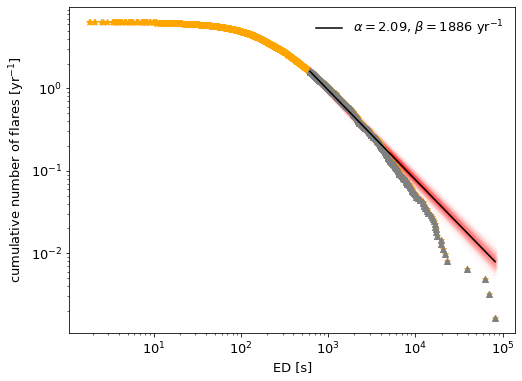

In [33]:
fig, ax =  plt.subplots(1, figsize=(8,6))

hasflares = (df.real==1) & (df.todrop.isnull())
ffd = FFD(f=df[hasflares], tot_obs_time=tobs, ID="EPIC")

#---------- No correction ----------------
ed, freq, counts = ffd.ed_and_freq(energy_correction=False,
                            recovery_probability_correction=False,
                             multiple_stars=False)
ax.scatter(ed, freq, c="orange", marker="*")#, label="no correction")


#---------- multiple stars 
ed, freq, counts = ffd.ed_and_freq(energy_correction=False,
                            recovery_probability_correction=False,
                             multiple_stars=True)

#ax.scatter(ffd.ed, ffd.freq, marker="^", c="c", label="correcting for multiple stars in sample")

cts = pd.Series(counts).value_counts()
thresh = cts[cts==1].sort_index().index.min() * 2.
ed, freq, counts = ffd.ed_and_freq(energy_correction=False,
                            recovery_probability_correction=False,
                             multiple_stars=False)

ffd.count_ed = ffd.count_ed[np.where(ffd.count_ed>thresh)]
ffd.ed = ed[np.where(ed>thresh)]
ffd.freq = freq[np.where(ed>thresh)]
print(len(ffd.ed))
ffd.alpha_prior = 1.99
ffd.beta_prior = 981.75
BFA = ffd.fit_mcmc_powerlaw(steps=200)
print(f"Fitted power law alpha={ffd.alpha}({ffd.alpha_up_err}/{ffd.alpha_low_err})")
print(f"Fitted power law beta={ffd.beta}({ffd.beta_up_err}/{ffd.beta_low_err})")

ispowerlaw = ffd.is_powerlaw()
truncated = ffd.is_powerlaw_truncated()

ffd.plot_mcmc_powerlaw(ax, BFA, subset=300, linewidth=5, c="r", alpha=.005, zorder=-1)
ax.scatter(ffd.ed, ffd.freq, marker="^", c="grey", )#label="all flaring stars contribute = above detection threshold")
a, x, y = ffd.plot_powerlaw(ax, c="k", 
                            label=(fr"$\alpha=${ffd.alpha:.2f}, "
                                   fr"$\beta=${int(np.rint(ffd.beta))}" + r" yr$^{-1}$"))

plt.xscale("log")
plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("ED [s]")
plt.ylabel(r"cumulative number of flares [yr$^{-1}$]")

resfullsample["alpha"] = ffd.alpha
resfullsample["alpha_up_err"] = ffd.alpha_up_err
resfullsample["alpha_low_err"] = ffd.alpha_low_err
resfullsample["beta"] = ffd.beta
resfullsample["beta_up_err"] = ffd.beta_up_err
resfullsample["beta_low_err"] = ffd.beta_low_err
resfullsample["nflares_tot"] = len(ed)
resfullsample["nflares_for_fit"] = len(ffd.ed)
resfullsample["ispowerlaw"] = ispowerlaw
resfullsample["istruncated"] = truncated

plt.savefig(f"plots/{tstamp}_full_sample_ffd_ED_wheatland.png", dpi=300)
plt.savefig(f"{paperdir}pics/FFDs/full_sample_ffd_ED_wheatland.png", dpi=300)

In [35]:
thresh

616.95634117643

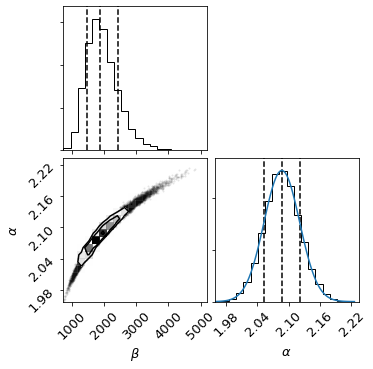

In [39]:
BFA.show_corner_plot(show_truths=False, show_titles=False)


x = np.linspace(resfullsample["alpha"] - resfullsample["alpha_low_err"]*4,
                resfullsample["alpha"] + resfullsample["alpha_up_err"]*4,100)
plt.plot(x, 435*gaussian_prior(x, resfullsample["alpha"], 
                            (resfullsample["alpha_up_err"] + resfullsample["alpha_low_err"]) / 2.))
plt.savefig(f"plots/{tstamp}_full_ED_FFD_cornerplot.png", dpi=300)

In [40]:
def loglikelihood_gauss_wheatland_ed(theta, *args):
    '''Log likelihood to pass to BayesianFlaringAnalysis
    for fitting the powerlaw following Wheatland 2004.
    Using a gaussian prior for alpha.
    '''
    def prior(x):
        return gaussian_prior(x, resfullsample["alpha"], 
                           (resfullsample["alpha_up_err"] + resfullsample["alpha_low_err"]) / 2.)
    return calculate_joint_posterior_distribution(theta, *args, prior)

1224


100%|██████████| 200/200 [00:03<00:00, 54.43it/s]


Fitted power law alpha=1.9866352967524377(0.02858952856004282/0.027693013656010734)
Fitted power law beta=4.793137364598649e+32(3.801223327775363e+33/4.219741912766107e+32)


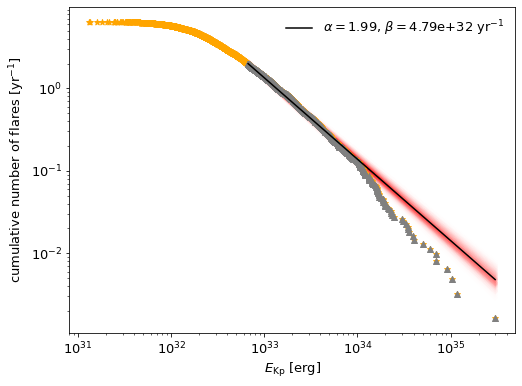

In [42]:
fig, ax =  plt.subplots(1, figsize=(8,6))
df2 = copy.deepcopy(df)
df2["ed_rec"] = df.ed_rec * df.Lum_Kepler
ffd = FFD(f=df2[hasflares & ~(df.ed_rec.isnull())], tot_obs_time=tobs, ID="EPIC")

#---------- No correction ----------------
ed, freq, counts = ffd.ed_and_freq(energy_correction=False,
                            recovery_probability_correction=False,
                             multiple_stars=False)
ax.scatter(ed, freq, c="orange", marker="*")#, label="no correction")


#---------- multiple stars 
ed, freq, counts = ffd.ed_and_freq(energy_correction=False,
                            recovery_probability_correction=False,
                             multiple_stars=True)

#ax.scatter(ffd.ed, ffd.freq, marker="^", c="c", label="correcting for multiple stars in sample")

cts = pd.Series(counts).value_counts()
thresh = cts[cts==1].sort_index().index.min() * 2.

ed, freq, counts = ffd.ed_and_freq(energy_correction=False,
                            recovery_probability_correction=False,
                             multiple_stars=False)

ffd.count_ed = ffd.count_ed[np.where(ffd.count_ed>thresh)]
ffd.ed = ed[np.where(ed>thresh)]
ffd.freq = freq[np.where(ed>thresh)]

ffd.alpha_prior = 1.85
ffd.beta_prior = 1.75e28
BFA = ffd.fit_mcmc_powerlaw(steps=200.)
print(f"Fitted power law alpha={ffd.alpha}({ffd.alpha_up_err}/{ffd.alpha_low_err})")
print(f"Fitted power law beta={ffd.beta}({ffd.beta_up_err}/{ffd.beta_low_err})")
ispowerlaw = ffd.is_powerlaw()
truncated = ffd.is_powerlaw_truncated()

ffd.plot_mcmc_powerlaw(ax, BFA, subset=300,linewidth=5, c="r", alpha=.005, zorder=-1)
ax.scatter(ffd.ed, ffd.freq, marker="^", c="grey")#, label="all flaring stars contribute = above detection threshold")
a, x, y = ffd.plot_powerlaw(ax, c="k", label=fr"$\alpha=${ffd.alpha:.2f}, $\beta=${ffd.beta:.2e}"  + r" yr$^{-1}$")


resfullsample["alpha_en"] = ffd.alpha
resfullsample["alpha_up_err_en"] = ffd.alpha_up_err
resfullsample["alpha_low_err_en"] = ffd.alpha_low_err
resfullsample["beta_en"] = ffd.beta
resfullsample["beta_up_err_en"] = ffd.beta_up_err
resfullsample["beta_low_err_en"] = ffd.beta_low_err
resfullsample["nflares_tot_en"] = len(ed)
resfullsample["nflares_for_fit_en"] = len(ffd.ed)
resfullsample["ispowerlaw_en"] = ispowerlaw
resfullsample["istruncated_en"] = truncated

plt.xscale("log")
plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel(r"$E_\mathrm{Kp}$ [erg]")
plt.ylabel(r"cumulative number of flares [yr$^{-1}$]")

plt.savefig(f"plots/{tstamp}_full_sample_ffd_energy_wheatland.png", dpi=300)
plt.savefig(f"{paperdir}pics/FFDs/full_sample_ffd_energy_wheatland.png", dpi=300)

In [44]:
thresh

6.682807309466223e+32

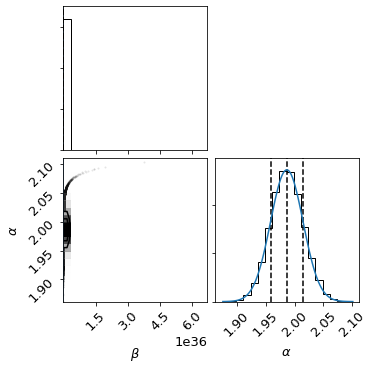

In [46]:
BFA.show_corner_plot(show_truths=False, show_titles=False)
x = np.linspace(resfullsample["alpha_en"] - resfullsample["alpha_low_err_en"]*4,
                resfullsample["alpha_en"] + resfullsample["alpha_up_err_en"]*4,100)
plt.plot(x, 385*gaussian_prior(x, resfullsample["alpha_en"], 
                            (resfullsample["alpha_up_err_en"] + resfullsample["alpha_low_err_en"]) / 2.))
plt.savefig(f"plots/{tstamp}_full_energy_FFD_cornerplot.png", dpi=300)

In [47]:
def loglikelihood_gauss_wheatland_energy(theta, *args):
    '''Log likelihood to pass to BayesianFlaringAnalysis
    for fitting the powerlaw following Wheatland 2004.
    Using a gaussian prior for alpha.
    '''
    def prior(x):
        return gaussian_prior(x, resfullsample["alpha_en"], 
                           (resfullsample["alpha_up_err_en"] + resfullsample["alpha_low_err_en"]) / 2.)
    return calculate_joint_posterior_distribution(theta, *args, prior)

In [61]:
_t = pd.Series(resfullsample)
resfulltab =  pd.DataFrame({"space": [r"$ED$", r"$E_\mathrm{Kp}$"],
              r"$\alpha$":[f"${_t.alpha:.2f}\left(OK1{_t.alpha_up_err:.2f}K2UK1{_t.alpha_up_err:.2f}K2\right)$",
                           f"${_t.alpha_en:.2f}\left(OK1{_t.alpha_up_err_en:.2f}K2UK1{_t.alpha_up_err_en:.2f}K2\right)$",],
              r"$\beta$ [yr$^{-1}$]":[f"${int(np.rint(_t.beta))}\left(OK1{int(np.rint(_t.beta_up_err))}K2UK1{int(np.rint(_t.beta_low_err))}K2\right)$",
                          f"${_t.beta_en/10**32:.2f}\left(OK1{_t.beta_up_err_en/10**32:.2f}K2UK1{_t.beta_low_err_en/10**32:.2f}K2\right)" + r"\cdot 10^{32}$"],
              r"$n_\mathrm{tot}$":[_t.nflares_tot,_t.nflares_tot_en,],
              r"$n_\mathrm{fit}$":[_t.nflares_for_fit,_t.nflares_for_fit_en,],
             # r"$tr$":[_t.istruncated,_t.istruncated_en,],
             # r"$pl$":[_t.ispowerlaw,_t.ispowerlaw_en,]
             })
_t.to_csv("tables/full_sample_alphabeta.csv")

In [62]:
resfulltab[r"$\alpha$"] = (resfulltab[r"$\alpha$"].str
                           .replace("O",r"^").str
                           .replace("U",r"_").str
                           .replace("K1",r"{").str
                           .replace("K2",r"}"))

resfulltab[r"$\beta$ [yr$^{-1}$]"] = (resfulltab[r"$\beta$ [yr$^{-1}$]"].str
                           .replace("O",r"^").str
                           .replace("U",r"_").str
                           .replace("K1",r"{").str
                           .replace("K2",r"}"))
names = resfulltab['space'].values
resfulltab = resfulltab.T

resfulltab = resfulltab.rename(index=str, columns=dict(zip(resfulltab.columns.values, names)))
resfulltab = resfulltab.drop("space")
nc = 'c' * (resfulltab.shape[1])
stri = resfulltab.to_latex(index=True,escape=False, column_format=f"l{nc}r")
stri = stri.replace("\\toprule","\hline")
stri = stri.replace("\\midrule","\hline")


stri = stri.replace("\\bottomrule","\hline\n" )
stri = stri.replace("{}"," " )

with open(f"{paperdir}tables/powerlaw_fullsample_wheatland.tex", "w") as f:
    f.write(stri)

print(stri)

\begin{tabular}{lccr}
\hline
  &                               $ED$ &                                  $E_\mathrm{Kp}$ \\
\hline
$\alpha$            &  $2.09\left(^{0.03}_{0.03}\right)$ &                $1.99\left(^{0.03}_{0.03}\right)$ \\
$\beta$ [yr$^{-1}$] &    $1886\left(^{548}_{417}\right)$ &  $4.79\left(^{38.01}_{4.22}\right)\cdot 10^{32}$ \\
$n_\mathrm{tot}$    &                               3937 &                                             3937 \\
$n_\mathrm{fit}$    &                                989 &                                             1224 \\
\hline

\end{tabular}



In [50]:
with open(f"{paperdir}values/MCMC_alpha_ed.txt", "w") as f:
    f.write(str(np.round(resfullsample["alpha"],2)))
with open(f"{paperdir}values/MCMC_alpha_energy.txt", "w") as f:
    f.write(str(np.round(resfullsample["alpha_en"],2)))

## Teff bins


In [51]:
labels=["2500-3000","3000-3250","3250-3500","3500-3750","3750-4000","4000-5000","5000-6000"]
bins_T = pd.cut(df["Teff_median"],
                bins=[2500,3000,3250,3500,3750,4000,5000,6000],
                labels=labels)
numer = ["a.","b.","c.","d.","e.","f.","g."]

/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


12


100%|██████████| 200/200 [00:02<00:00, 74.12it/s]
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/ffd.py:431: UserWarning: Power law exponent is steep. Power of statistical tests decreases according to Maschberger and Kroupa 2009.
  warnings.warn('Power law exponent is steep. '


Fitted power law alpha=2.08884123759678(0.03428240020891238/0.0339492361525604)
Fitted power law beta=2581.8383052873537(1185.4870135587694/845.8488570018014)
10


100%|██████████| 200/200 [00:02<00:00, 78.96it/s]
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/ffd.py:431: UserWarning: Power law exponent is steep. Power of statistical tests decreases according to Maschberger and Kroupa 2009.
  warnings.warn('Power law exponent is steep. '


Fitted power law alpha=2.0871416445249693(0.0338329878215613/0.033908193497043104)
Fitted power law beta=8230.93147437381(4053.1081371024084/2777.3863637284976)
5


100%|██████████| 200/200 [00:02<00:00, 79.82it/s]
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/ffd.py:431: UserWarning: Power law exponent is steep. Power of statistical tests decreases according to Maschberger and Kroupa 2009.
  warnings.warn('Power law exponent is steep. '
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Fitted power law alpha=2.088801937895066(0.03381590234879761/0.033540773087858966)
Fitted power law beta=2684.632758581257(1635.337693864497/1088.9010193080176)
272


100%|██████████| 200/200 [00:03<00:00, 66.19it/s]
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/ffd.py:431: UserWarning: Power law exponent is steep. Power of statistical tests decreases according to Maschberger and Kroupa 2009.
  warnings.warn('Power law exponent is steep. '


Fitted power law alpha=2.0806692478399027(0.030302904099622996/0.029852422799243605)
Fitted power law beta=4615.343355964254(1176.9254808227988/924.9001125615468)
77


100%|██████████| 200/200 [00:02<00:00, 75.58it/s]
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/ffd.py:431: UserWarning: Power law exponent is steep. Power of statistical tests decreases according to Maschberger and Kroupa 2009.
  warnings.warn('Power law exponent is steep. '


Fitted power law alpha=2.070245542279088(0.032406192007900625/0.03251777757892693)
Fitted power law beta=2474.341360236028(662.6694489058236/523.9216686993188)
290


100%|██████████| 200/200 [00:02<00:00, 69.10it/s]
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/ffd.py:431: UserWarning: Power law exponent is steep. Power of statistical tests decreases according to Maschberger and Kroupa 2009.
  warnings.warn('Power law exponent is steep. '
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Fitted power law alpha=2.0626845641724763(0.029559333555855716/0.029916508564160615)
Fitted power law beta=2501.0986187724275(643.4917285396577/512.0677066089565)
314


100%|██████████| 200/200 [00:03<00:00, 63.11it/s]
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/ffd.py:431: UserWarning: Power law exponent is steep. Power of statistical tests decreases according to Maschberger and Kroupa 2009.
  warnings.warn('Power law exponent is steep. '


Fitted power law alpha=2.0712776836828204(0.030169247849642034/0.029853539399896434)
Fitted power law beta=3420.8272365658368(748.9375501185714/611.5787363034601)
83


100%|██████████| 200/200 [00:02<00:00, 74.87it/s]
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/ffd.py:431: UserWarning: Power law exponent is steep. Power of statistical tests decreases according to Maschberger and Kroupa 2009.
  warnings.warn('Power law exponent is steep. '


Fitted power law alpha=2.083495710942966(0.032424660641304115/0.0328223622666437)
Fitted power law beta=2018.5625624890333(491.8945603312379/400.7305928090698)
621


100%|██████████| 200/200 [00:03<00:00, 59.87it/s]
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/ffd.py:431: UserWarning: Power law exponent is steep. Power of statistical tests decreases according to Maschberger and Kroupa 2009.
  warnings.warn('Power law exponent is steep. '


Fitted power law alpha=2.0136933778694384(0.026473244438248944/0.02596155285503121)
Fitted power law beta=1144.0723938030283(204.38790105976568/171.38618383155483)
4


100%|██████████| 200/200 [00:02<00:00, 80.51it/s]


Fitted power law alpha=2.087644608615343(0.03367227214832358/0.03392503370971811)
Fitted power law beta=312.7402989777469(183.77102892939837/127.4588952428062)
74


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/ffd.py:431: UserWarning: Power law exponent is steep. Power of statistical tests decreases according to Maschberger and Kroupa 2009.
  warnings.warn('Power law exponent is steep. '
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
100%|██████████| 200/200 [00:02<00:00, 73.54it/s]
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/ffd.py:431: UserWarning: Power law exponent is steep. Power of statistical tests decreases according to Maschberger and Kroup

Fitted power law alpha=2.0835028556186885(0.03293780368186061/0.03288161601207129)
Fitted power law beta=1563.2963569002104(370.84330092568644/300.4046223027376)
28


100%|██████████| 200/200 [00:02<00:00, 76.21it/s]
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/ffd.py:431: UserWarning: Power law exponent is steep. Power of statistical tests decreases according to Maschberger and Kroupa 2009.
  warnings.warn('Power law exponent is steep. '


Fitted power law alpha=2.0873274784683344(0.033620364809193504/0.03368711188666351)
Fitted power law beta=1269.4667827348812(371.3287102345132/294.80907884490455)
76


100%|██████████| 200/200 [00:02<00:00, 73.91it/s]


Fitted power law alpha=2.0795844890488318(0.03320886426882996/0.03277325470809256)
Fitted power law beta=195.29701232961102(42.33824179675858/35.004591956239295)
36


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/ffd.py:431: UserWarning: Power law exponent is steep. Power of statistical tests decreases according to Maschberger and Kroupa 2009.
  warnings.warn('Power law exponent is steep. '
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
100%|██████████| 200/200 [00:02<00:00, 75.25it/s]
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/ffd.py:431: UserWarning: Power law exponent is steep. Power of statistical tests decreases according to Maschberger and Kroup

Fitted power law alpha=2.0957030366097458(0.0333809157030438/0.03350983797257179)
Fitted power law beta=1312.2150569786395(363.11762269326687/288.5229563052833)
19


100%|██████████| 200/200 [00:02<00:00, 76.35it/s]


Fitted power law alpha=2.0865069737982678(0.03336668971512724/0.03422654137183345)
Fitted power law beta=53.10236463060198(15.81624604713737/12.679284226925184)
1


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/ffd.py:431: UserWarning: Power law exponent is steep. Power of statistical tests decreases according to Maschberger and Kroupa 2009.
  warnings.warn('Power law exponent is steep. '
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 200/200 [00:02<00:00, 80.91it/s]


Fitted power law alpha=2.088007584946529(0.034100983740410484/0.03371359238546745)
Fitted power law beta=14.64318489855301(14.766578342456775/8.591118669966924)
55


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/ffd.py:431: UserWarning: Power law exponent is steep. Power of statistical tests decreases according to Maschberger and Kroupa 2009.
  warnings.warn('Power law exponent is steep. '
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/ffd.py:877: RuntimeWarning: invalid value encountered in true_divide
  (expa(np.max(data), alpha) - expa(np.min(data), alpha)))
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
100%|██████████| 200/200 [00:02<00:00, 74.87it/

Fitted power law alpha=2.083498708872094(0.03317100288768371/0.033147951802457776)
Fitted power law beta=884.3790834990474(232.6714559942901/184.14874289249826)
7


100%|██████████| 200/200 [00:02<00:00, 74.26it/s]


Fitted power law alpha=2.0858487850361693(0.033931834702461305/0.033878998480811884)
Fitted power law beta=20.483415616997256(8.965474762213535/6.702259541871754)
39


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/ffd.py:431: UserWarning: Power law exponent is steep. Power of statistical tests decreases according to Maschberger and Kroupa 2009.
  warnings.warn('Power law exponent is steep. '
100%|██████████| 200/200 [00:02<00:00, 75.94it/s]


Fitted power law alpha=2.0812935936971266(0.03311755815172823/0.033339390063413354)
Fitted power law beta=22.98661403945443(5.005962697323106/4.213392880868511)
19


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/ffd.py:431: UserWarning: Power law exponent is steep. Power of statistical tests decreases according to Maschberger and Kroupa 2009.
  warnings.warn('Power law exponent is steep. '
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
100%|██████████| 200/200 [00:02<00:00, 76.45it/s]


Fitted power law alpha=2.079919916616408(0.033899361920020965/0.03391529226396939)
Fitted power law beta=68.1707325383239(20.434716757858297/16.365923321833662)
53


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/ffd.py:431: UserWarning: Power law exponent is steep. Power of statistical tests decreases according to Maschberger and Kroupa 2009.
  warnings.warn('Power law exponent is steep. '
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 200/200 [00:02<00:00, 75.82it/s]


Fitted power law alpha=2.0798802398947114(0.03347131130337333/0.032978005681993494)
Fitted power law beta=18.239680460046138(3.42928079501878/2.951975772903726)
4


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/ffd.py:431: UserWarning: Power law exponent is steep. Power of statistical tests decreases according to Maschberger and Kroupa 2009.
  warnings.warn('Power law exponent is steep. '
100%|██████████| 200/200 [00:02<00:00, 77.91it/s]


Fitted power law alpha=2.0870736959588885(0.03392241050724998/0.033818423217613525)
Fitted power law beta=61.8518429901824(36.469375021212336/25.14570475377085)
1


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/ffd.py:431: UserWarning: Power law exponent is steep. Power of statistical tests decreases according to Maschberger and Kroupa 2009.
  warnings.warn('Power law exponent is steep. '
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 200/200 [00:02<00:00, 82.76it/s]


Fitted power law alpha=2.0878475724272825(0.0338974440367279/0.03393739660660566)
Fitted power law beta=3.698871249082863(3.671732884289257/2.1686481919825438)


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/ffd.py:431: UserWarning: Power law exponent is steep. Power of statistical tests decreases according to Maschberger and Kroupa 2009.
  warnings.warn('Power law exponent is steep. '
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/ffd.py:877: RuntimeWarning: invalid value encountered in true_divide
  (expa(np.max(data), alpha) - expa(np.min(data), alpha)))


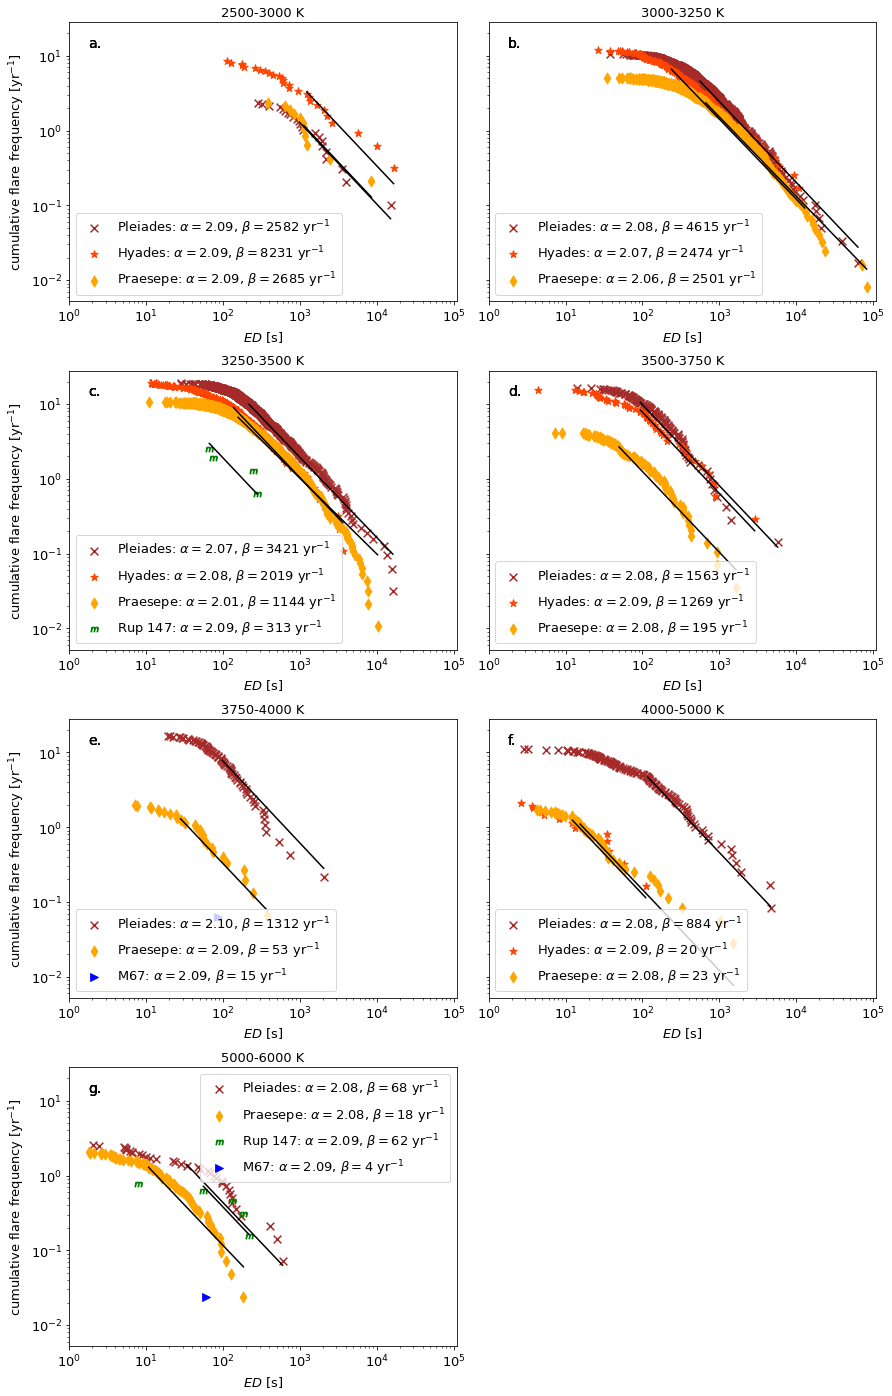

In [52]:
resed = {}

fig, axes = plt.subplots(nrows=4,ncols=2,figsize=(12.5,19.5), sharey=True, squeeze=True)
k = 0
axes = [l for x in axes for l in x]
for i, g in df.groupby(bins_T):
    g.loc[:,"cluster"] = pd.Categorical(g.cluster, 
                      categories=["pleiades","hyades","praesepe","ngc6774", "ngc2682"],
                      ordered=True)
    resed[i]={}
    for j, h in g.groupby("cluster"):

        tobs = T[(T.Teff_median == i) & (T.cluster == j)].LC_time_years.values[0]
        h = h[(h.real == 1)]
        if h.shape[0] == 0:
            continue
        else:
            ffd = FFD(f=h, tot_obs_time=tobs, ID="EPIC")

            #---------- get thershold
            
            ed, freq, counts = ffd.ed_and_freq(energy_correction=False,
                                        recovery_probability_correction=False,
                                         multiple_stars=True)
            
            cts = pd.Series(counts).value_counts()
            thresh = cts[cts==1].sort_index().index.min()
            
            # ----------- use threshold
            
            ed, freq, counts = ffd.ed_and_freq(energy_correction=False,
                                        recovery_probability_correction=False,
                                         multiple_stars=False)
            
            ffd.count_ed = ffd.count_ed[np.where(ffd.count_ed>=thresh)]
            ffd.ed = ed[np.where(ed>=thresh)]
            ffd.freq = freq[np.where(ed>=thresh)]

            ffd.alpha_prior = resfullsample["alpha"]
            ffd.beta_prior = resfullsample["beta"]

            BFA = ffd.fit_mcmc_powerlaw(steps=200,loglikelihood=loglikelihood_gauss_wheatland_ed)
            print(f"Fitted power law alpha={ffd.alpha}({ffd.alpha_up_err}/{ffd.alpha_low_err})")
            print(f"Fitted power law beta={ffd.beta}({ffd.beta_up_err}/{ffd.beta_low_err})")
            
                
            a, x, y = ffd.plot_powerlaw(axes[k], c="k",)
            
            resed[i][ccol[j][0]]={"alpha":ffd.alpha,
                                  "alpha_up_err":ffd.alpha_up_err,
                                  "alpha_low_err":ffd.alpha_low_err,
                                  "beta":ffd.beta,
                                  "beta_up_err":ffd.beta_up_err,
                                  "beta_low_err":ffd.beta_low_err,
                                  "nflares":len(ed),
                                  "age":ccol[j][3],
                                  "age_uperr":ccol[j][4],
                                  "age_lowerr":ccol[j][5],
                                  "ispowerlaw":ffd.is_powerlaw(),
                                  "istruncated": ffd.is_powerlaw_truncated()
                                  }
            
            ed, freq, counts = ffd.ed_and_freq(energy_correction=False,
                                        recovery_probability_correction=False,
                                         multiple_stars=False)

            axes[k].scatter(ed, freq, c=ccol[j][1], marker=ccol[j][2], s=60,
                            label=fr"{ccol[j][0]}: $\alpha=${ffd.alpha:.2f}, $\beta=${ffd.beta:.0f}" + r" yr$^{-1}$")

            axes[k].set_xscale('log')
            axes[k].set_yscale('log')
            axes[k].set_title(f"{i} K")
            axes[k].set_xlim(1, 1.1e5)
            axes[k].set_xlabel(r"$ED$ [s]")
            axes[k].text(0.05, 0.9, numer[k], horizontalalignment='left',fontsize=14,
                         verticalalignment='bottom', transform=axes[k].transAxes)
            if k==6:
                axes[k].legend(loc=1)
            else:
                axes[k].legend(loc=3)

            
            
    k += 1
axes[-1].axis('off')
for i in [0,2,4,6]:
    axes[i].set_ylabel(r"cumulative flare frequency [yr$^{-1}$]")

plt.tight_layout()
plt.savefig(f"plots/{tstamp}_SpT_wise_sample_ffd_ED_wheatland.png", dpi=300)
plt.savefig(f"{paperdir}pics/FFDs/SpT_wise_sample_ffd_ED_wheatland.png", dpi=300)

/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


12


100%|██████████| 200/200 [00:02<00:00, 74.47it/s]


Fitted power law alpha=1.99(0.03/0.03)
Fitted power law beta=8.09e+31(5.96e+32/7.13e+31)
14


100%|██████████| 200/200 [00:02<00:00, 68.64it/s]


Fitted power law alpha=1.99(0.03/0.03)
Fitted power law beta=2.12e+32(1.57e+33/1.86e+32)
4


100%|██████████| 200/200 [00:02<00:00, 77.62it/s]


Fitted power law alpha=1.99(0.03/0.03)
Fitted power law beta=8.54e+31(6.54e+32/7.52e+31)


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


314


100%|██████████| 200/200 [00:02<00:00, 66.67it/s]
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/ffd.py:431: UserWarning: Power law exponent is steep. Power of statistical tests decreases according to Maschberger and Kroupa 2009.
  warnings.warn('Power law exponent is steep. '


Fitted power law alpha=2.00(0.03/0.02)
Fitted power law beta=1.28e+33(7.23e+33/1.08e+33)
79


100%|██████████| 200/200 [00:02<00:00, 72.23it/s]


Fitted power law alpha=1.98(0.03/0.03)
Fitted power law beta=1.86e+32(1.26e+33/1.62e+32)
315


100%|██████████| 200/200 [00:02<00:00, 67.54it/s]
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Fitted power law alpha=1.98(0.02/0.03)
Fitted power law beta=2.94e+32(1.64e+33/2.51e+32)
335


100%|██████████| 200/200 [00:03<00:00, 65.30it/s]
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/ffd.py:431: UserWarning: Power law exponent is steep. Power of statistical tests decreases according to Maschberger and Kroupa 2009.
  warnings.warn('Power law exponent is steep. '


Fitted power law alpha=2.00(0.03/0.02)
Fitted power law beta=4.00e+33(2.28e+34/3.40e+33)
91


100%|██████████| 200/200 [00:02<00:00, 73.65it/s]


Fitted power law alpha=1.98(0.03/0.03)
Fitted power law beta=6.28e+32(4.27e+33/5.46e+32)
689


100%|██████████| 200/200 [00:03<00:00, 57.67it/s]


Fitted power law alpha=1.96(0.02/0.02)
Fitted power law beta=1.03e+32(4.53e+32/8.43e+31)
4


100%|██████████| 200/200 [00:02<00:00, 79.48it/s]
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Fitted power law alpha=1.99(0.03/0.03)
Fitted power law beta=9.95e+31(7.66e+32/8.75e+31)
78


100%|██████████| 200/200 [00:02<00:00, 74.33it/s]


Fitted power law alpha=1.99(0.03/0.03)
Fitted power law beta=1.67e+33(1.16e+34/1.46e+33)
20


100%|██████████| 200/200 [00:02<00:00, 75.10it/s]


Fitted power law alpha=1.99(0.03/0.03)
Fitted power law beta=2.08e+33(1.53e+34/1.83e+33)
75


100%|██████████| 200/200 [00:02<00:00, 73.77it/s]
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Fitted power law alpha=1.98(0.03/0.03)
Fitted power law beta=1.62e+32(1.11e+33/1.41e+32)
36


100%|██████████| 200/200 [00:02<00:00, 76.53it/s]


Fitted power law alpha=2.00(0.03/0.03)
Fitted power law beta=6.78e+33(5.16e+34/5.98e+33)
18


100%|██████████| 200/200 [00:02<00:00, 75.29it/s]


Fitted power law alpha=1.99(0.03/0.03)
Fitted power law beta=2.30e+32(1.71e+33/2.04e+32)
1


100%|██████████| 200/200 [00:02<00:00, 80.49it/s]


Fitted power law alpha=1.99(0.03/0.03)
Fitted power law beta=4.78e+31(4.20e+32/4.30e+31)
59


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/ffd.py:877: RuntimeWarning: invalid value encountered in true_divide
  (expa(np.max(data), alpha) - expa(np.min(data), alpha)))
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
100%|██████████| 200/200 [00:02<00:00, 72.15it/s]


Fitted power law alpha=1.98(0.03/0.03)
Fitted power law beta=3.93e+33(2.90e+34/3.47e+33)
6


100%|██████████| 200/200 [00:02<00:00, 76.72it/s]


Fitted power law alpha=1.99(0.03/0.03)
Fitted power law beta=1.75e+32(1.40e+33/1.55e+32)
34


100%|██████████| 200/200 [00:02<00:00, 75.34it/s]
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Fitted power law alpha=1.98(0.03/0.03)
Fitted power law beta=1.80e+32(1.34e+33/1.58e+32)
19


100%|██████████| 200/200 [00:02<00:00, 78.29it/s]


Fitted power law alpha=1.98(0.03/0.03)
Fitted power law beta=2.14e+33(1.78e+34/1.89e+33)
54


100%|██████████| 200/200 [00:02<00:00, 76.68it/s]


Fitted power law alpha=1.98(0.03/0.03)
Fitted power law beta=3.67e+32(2.68e+33/3.23e+32)
4


100%|██████████| 200/200 [00:02<00:00, 78.80it/s]


Fitted power law alpha=1.99(0.03/0.03)
Fitted power law beta=1.51e+33(1.30e+34/1.35e+33)
1


100%|██████████| 200/200 [00:02<00:00, 81.60it/s]
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/ffd.py:877: RuntimeWarning: invalid value encountered in true_divide
  (expa(np.max(data), alpha) - expa(np.min(data), alpha)))


Fitted power law alpha=1.99(0.03/0.03)
Fitted power law beta=8.81e+31(8.23e+32/8.00e+31)


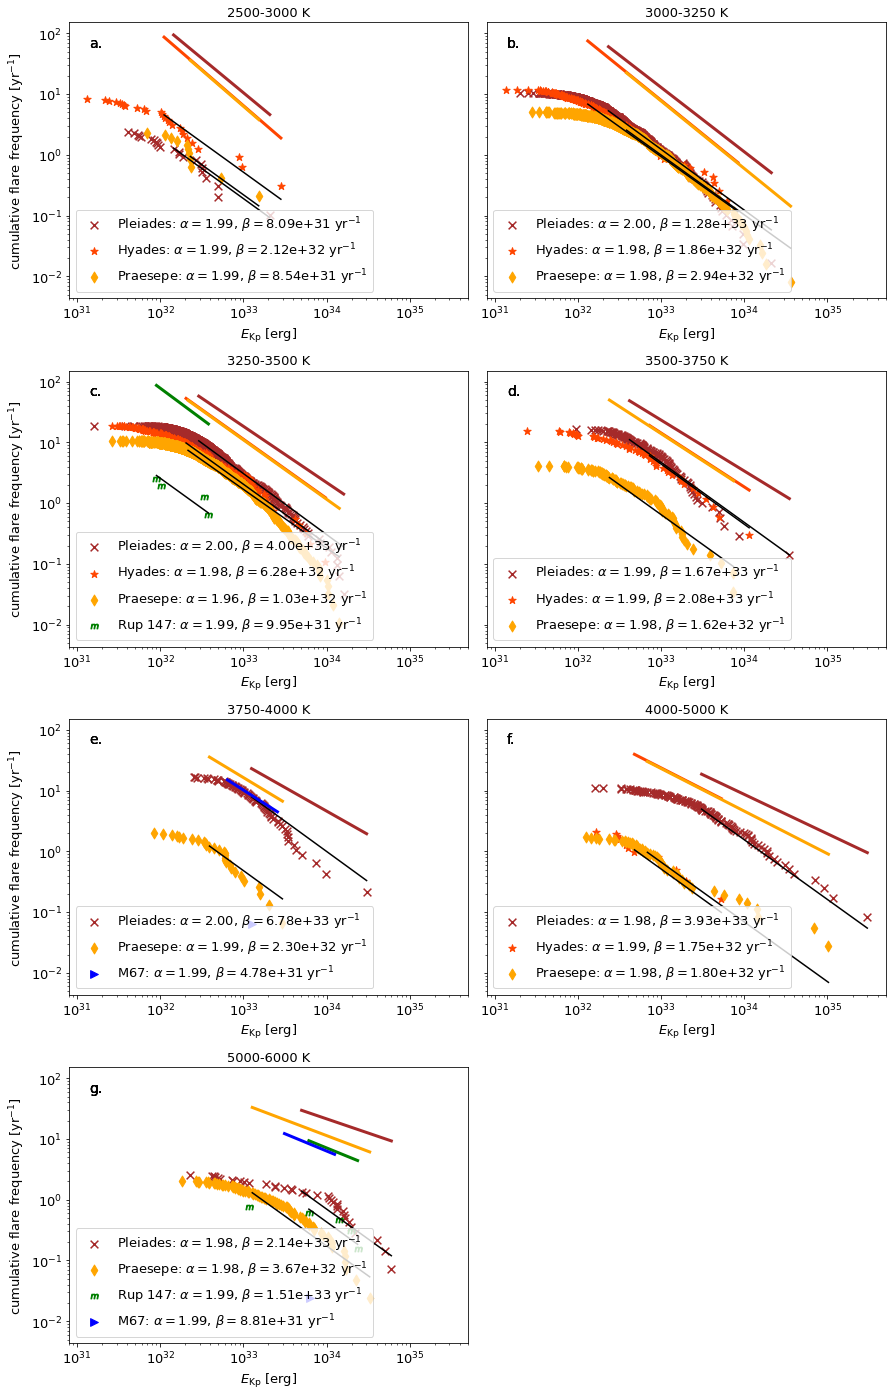

In [53]:
resen = {}
df2 = copy.deepcopy(df)
df2["ed_rec"] = df.ed_rec * df.Lum_Kepler
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12.5,19.5),
                         sharey=True, squeeze=True)
k = 0
axes = [l for x in axes for l in x]

for i, g in df2.groupby(bins_T):
    resen[i]={}
    g.loc[:,"cluster"] = pd.Categorical(g.cluster, 
                      categories=["pleiades","hyades",
                                  "praesepe","ngc6774",
                                  "ngc2682"],
                      ordered=True)
    for j, h in g.groupby("cluster"):
        tobs = T[(T.Teff_median == i) &
                 (T.cluster == j)].LC_time_years.values[0]
        h = h[(h.real == 1)]
        if h.shape[0] == 0:
            continue
        else:
            ffd = FFD(f=h, tot_obs_time=tobs, ID="EPIC")

            #---------- get thershold
            
            ed, freq, counts = ffd.ed_and_freq(energy_correction=False,
                                        recovery_probability_correction=False,
                                         multiple_stars=True)
            
            cts = pd.Series(counts).value_counts()
            thresh = cts[cts==1].sort_index().index.min()
            
            # ----------- use threshold
            
            ed, freq, counts = ffd.ed_and_freq(energy_correction=False,
                                        recovery_probability_correction=False,
                                         multiple_stars=False)
            
            ffd.count_ed = ffd.count_ed[np.where(ffd.count_ed>=thresh)]
            ffd.ed = ed[np.where(ed>=thresh)]
            ffd.freq = freq[np.where(ed>=thresh)]

            ffd.alpha_prior = resfullsample["alpha_en"]
            ffd.beta_prior = resfullsample["beta_en"]
            
            BFA = ffd.fit_mcmc_powerlaw(steps=200,loglikelihood=loglikelihood_gauss_wheatland_energy)
            print(f"Fitted power law alpha={ffd.alpha:.2f}({ffd.alpha_up_err:.2f}/{ffd.alpha_low_err:.2f})")
            print(f"Fitted power law beta={ffd.beta:.2e}({ffd.beta_up_err:.2e}/{ffd.beta_low_err:.2e})")
            
            a, x, y = ffd.plot_powerlaw(axes[k], c="k",)
            
            # Add Davenport model
            ab = T[(T.cluster==j) & (T.Teff_median==i)]
            A = 1. - ab.alpha.iloc[0]
            B = np.power(10, ab.beta.iloc[0]) * (A - 1.) * 365.25
            ffdd = FFD(alpha=A, beta=B)
            ffdd.ed = ffd.ed
            if len(ffdd.ed) == 1:
                ffdd.ed = [ffdd.ed/2.,ffdd.ed*2.]
            a, x, y = ffdd.plot_powerlaw(axes[k], c=ccol[j][1], linewidth=3)
            # ----------------------------------------------------------------
            resen[i][ccol[j][0]]= {"alpha_en":ffd.alpha,
                                  "alpha_up_err_en":ffd.alpha_up_err,
                                  "alpha_low_err_en":ffd.alpha_low_err,
                                  "beta_en":ffd.beta,
                                  "beta_up_err_en":ffd.beta_up_err,
                                  "beta_low_err_en":ffd.beta_low_err,
                                  "nflares_en":len(ed),
                                  "age":ccol[j][3],
                                  "age_uperr":ccol[j][4],
                                  "age_lowerr":ccol[j][5],
                                  "ispowerlaw_en":ffd.is_powerlaw(),
                                  "istruncated_en": ffd.is_powerlaw_truncated(),
                                  "davenport_alpha": A,
                                  "davenport_beta":B,
                                  }
            
            ed, freq, counts = ffd.ed_and_freq(energy_correction=False,
                                        recovery_probability_correction=False,
                                         multiple_stars=False)
            
            axes[k].scatter(ed, freq, c=ccol[j][1], marker=ccol[j][2], s=60,
                           label=fr"{ccol[j][0]}: $\alpha=${ffd.alpha:.2f}, $\beta=${ffd.beta:.2e}"   + r" yr$^{-1}$")

            axes[k].set_xscale('log')
            axes[k].set_yscale('log')
            axes[k].set_title(f"{i} K")
            axes[k].set_xlim(8e30, 5e35)
            axes[k].set_xlabel(r"$E_\mathrm{Kp}$ [erg]")
            axes[k].text(0.05, 0.9, numer[k], horizontalalignment='left',fontsize=14,
                         verticalalignment='bottom', transform=axes[k].transAxes)
            axes[k].legend(loc=3)
            
            
    k += 1
axes[-1].axis('off')
for i in [0,2,4,6]:
    axes[i].set_ylabel(r"cumulative flare frequency [yr$^{-1}$]")

plt.tight_layout()
plt.savefig(f"plots/{tstamp}_SpT_wise_sample_ffd_energy_wheatland.png", dpi=300)
plt.savefig(f"{paperdir}pics/FFDs/SpT_wise_sample_ffd_energy_wheatland.png", dpi=300)

In [54]:
reform = {(outerKey, innerKey): values for outerKey, innerDict in resed.items() for innerKey, values in innerDict.items()}

betaed_ = pd.DataFrame(reform).T
betaed = betaed_.reset_index().rename(index=str, columns={"level_0":"Teff",
                                                                          "level_1":"cluster"}) 

reform = {(outerKey, innerKey): values for outerKey, innerDict in resen.items() for innerKey, values in innerDict.items()}

betaen_ = pd.DataFrame(reform).T
betaen = betaen_.reset_index().rename(index=str, columns={"level_0":"Teff",
                                                                       "level_1":"cluster"})
beta = betaed.merge(betaen)
beta["Tmin"] = beta.Teff.apply(lambda x: int(x.split("-")[0]))
beta["Tmax"] = beta.Teff.apply(lambda x: int(x.split("-")[1]))
beta["Tmid"] = ((beta.Tmax + beta.Tmin) / 2).astype(int)
beta["Tmid_err"] = ((beta.Tmax - beta.Tmin) / 2).astype(int)
beta.to_csv("tables/cluster_SpT_alphabeta.csv",index=False)
beta.sort_values(by="nflares")

,Teff,cluster,alpha,alpha_up_err,alpha_low_err,beta,beta_up_err,beta_low_err,nflares,age,...,beta_low_err_en,nflares_en,ispowerlaw_en,istruncated_en,davenport_alpha,davenport_beta,Tmin,Tmax,Tmid,Tmid_err
22,5000-6000,M67,2.08785,0.0338974,0.0339374,3.69887,3.67173,2.16865,1,3639,...,7.99727e+31,1,False,True,1.56667,6.64498e+19,5000,6000,5500,500
15,3750-4000,M67,2.08801,0.034101,0.0337136,14.6432,14.7666,8.59112,1,3639,...,4.29677e+31,1,False,True,1.87477,6.6002e+29,3750,4000,3875,125
9,3250-3500,Rup 147,2.08764,0.0336723,0.033925,312.74,183.771,127.459,4,2650,...,8.74679e+31,4,True,False,2.01523,2.43152e+34,3250,3500,3375,125
21,5000-6000,Rup 147,2.08707,0.0339224,0.0338184,61.8518,36.4694,25.1457,5,2650,...,1.35095e+33,5,True,False,1.55703,3.45295e+19,5000,6000,5500,500
2,2500-3000,Praesepe,2.0888,0.0338159,0.0335408,2684.63,1635.34,1088.9,11,750,...,7.52244e+31,11,True,False,2.18462,9.23621e+39,2500,3000,2750,250
17,4000-5000,Hyades,2.08585,0.0339318,0.033879,20.4834,8.96547,6.70226,13,690,...,1.55281e+32,13,True,False,1.69782,1.76165e+24,4000,5000,4500,500
0,2500-3000,Pleiades,2.08884,0.0342824,0.0339492,2581.84,1185.49,845.849,23,135,...,7.13112e+31,23,True,False,2.13249,2.8122e+38,2500,3000,2750,250
1,2500-3000,Hyades,2.08714,0.033833,0.0339082,8230.93,4053.11,2777.39,27,690,...,1.85556e+32,27,True,False,2.18209,7.7943e+39,2500,3000,2750,250
14,3750-4000,Praesepe,2.08651,0.0333667,0.0342265,53.1024,15.8162,12.6793,30,750,...,2.03699e+32,30,True,False,1.82675,2.60819e+28,3750,4000,3875,125
19,5000-6000,Pleiades,2.07992,0.0338994,0.0339153,68.1707,20.4347,16.3659,36,135,...,1.89345e+33,36,True,False,1.46652,7.28508e+16,5000,6000,5500,500


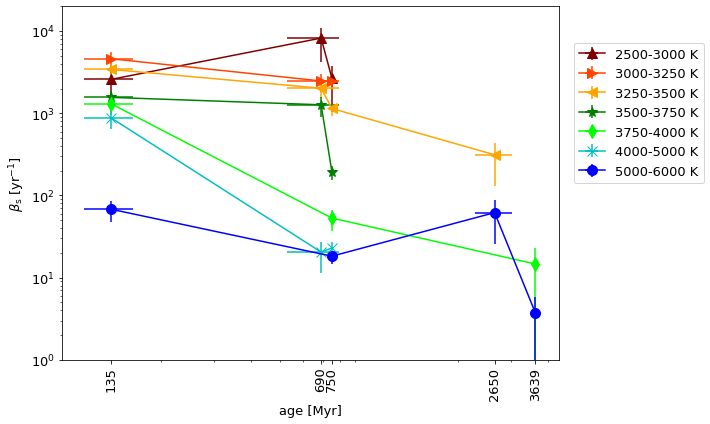

In [57]:
fig, ax = plt.subplots(figsize=(10,6))
Tcols = {"2750":["^","maroon"],
         "3125":[">","orangered"],
         "3375":["<","orange"],
         "3625":["*","green"],
         "3875":["d","lime"],
         "4500":["x","c"],
         "5500":["o","blue"],}
for label, g in beta.groupby("Tmid"):
 
    g.loc[:,"cluster"] = pd.Categorical(g.cluster, 
                      categories=["Pleiades","Hyades","Praesepe","Rup 147", "M67"],
                      ordered=True)
    g = g.sort_values(by="cluster")
    ax.errorbar(x=g.age, xerr=g[["age_uperr","age_lowerr"]].values.T,
                 y=g.beta, yerr=g[["beta_up_err","beta_low_err"]].values.T,
                 label=f"{g.Tmin.iloc[0]}-{g.Tmax.iloc[0]} K",c=Tcols[str(label)][1],
                  marker=Tcols[str(label)][0],markersize=10)
#     g.plot(x="age", xerr="age_uperr",y="beta",yerr="beta_err",
#            label=f"{g.Tmin.iloc[0]}-{g.Tmax.iloc[0]} K", ax=ax, kind="line",c=Tcols[str(label)][1],
#           marker=Tcols[str(label)][0],markersize=10)#s=120,)#
    

ax.set_xlabel("age [Myr]")
ax.set_ylabel(r"$\beta_\mathrm{s}$ [yr$^{-1}$]")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xticks(beta.age.astype(float).unique())
ax.set_xticklabels(labels=beta.age.unique(), rotation=90)
ax.set_ylim(1,2e4)
ax.legend(loc=(1.03,.5))
plt.tight_layout()
plt.savefig(f"plots/{tstamp}_beta_T_age_ED_wheatland.png", dpi=300)
plt.savefig(f"{paperdir}pics/FFDs/beta_T_age_ED_wheatland.png", dpi=300)

In [58]:
beta_s = betaen_.merge(betaed_, left_index=True,right_index=True)
for b in ["beta","beta_up_err","beta_low_err",
          "beta_en","beta_up_err_en", "beta_low_err_en"]:
    beta_s.loc[:,b] = beta_s[b].astype(float)


for out, beta, beta_up_err, beta_low_err in [(r"$\beta_\mathrm{s}$","beta","beta_up_err", "beta_low_err"),
                                             (r"$\beta_\mathrm{erg}$","beta_en","beta_up_err_en", "beta_low_err_en"),
                                           
                            ]:
    if out == r"$\beta_\mathrm{erg}$":
        beta_s["perr"] = (np.rint(np.log10(beta_s[beta]/beta_s[beta_up_err]))+2).astype(int)
        beta_s["b"] = (np.rint(np.log10(beta_s[beta]))).astype(int)
        beta_s["berr"] = (np.rint(np.log10(beta_s[beta_up_err]))).astype(int)
        beta_s["B"] = beta_s.apply(lambda x: np.round(x[beta]/10**x.b, x.perr).astype(str), axis=1)
        beta_s["Berr_up"] = beta_s.apply(lambda x: np.round(x[beta_up_err]/10**x.b, x.perr), axis=1)     
        beta_s["Berr_low"] = beta_s.apply(lambda x: np.round(x[beta_low_err]/10**x.b, x.perr), axis=1) 
    
        beta_s[out] = beta_s.apply(lambda x: f"${x.B}\left(OK1{x.Berr_up}K2UK1{x.Berr_low}K2\right)\cdot 10OK1{x.b}K2$", axis=1)
    else: 
        beta_s[out] = beta_s.apply(lambda x: f"${int(x[beta])}\left(OK1{int(x[beta_up_err])}K2UK1{int(x[beta_low_err])}K2\right)$", axis=1)
    beta_s[out] = (beta_s[out].str
                           .replace("O",r"^").str
                           .replace("U",r"_").str
                           .replace("K1",r"{").str
                           .replace("K2",r"}"))

    
for out, beta, beta_up_err, beta_low_err in [(r"$\alpha_\mathrm{erg}$","alpha_en","alpha_up_err_en", "alpha_low_err_en"),
                                             (r"$\alpha_\mathrm{s}$","alpha","alpha_up_err", "alpha_low_err"),
                            ]:    
    beta_s[out] = beta_s.apply(lambda x: f"${x[beta]:.2f}\left(OK1{x[beta_up_err]:.2f}K2UK1{x[beta_low_err]:.2f}K2\right)$", axis=1)
    beta_s[out] = (beta_s[out].str
                           .replace("O",r"^").str
                           .replace("U",r"_").str
                           .replace("K1",r"{").str
                           .replace("K2",r"}"))    
    
rename = {"nflares":r"$n_\mathrm{s}$",
         "nflares_en":r"$n_\mathrm{erg}$",
        #  "istruncated":r"$tr_\mathrm{s}$",
        # "istruncated_en":r"$tr_\mathrm{erg}$",
        # "ispowerlaw":r"$pl_\mathrm{s}$",
        # "ispowerlaw_en":r"$pl_\mathrm{erg}$",
         }
beta_s = beta_s[[r"$\alpha_\mathrm{s}$",r"$\beta_\mathrm{s}$","nflares",#"istruncated","ispowerlaw",,"istruncated_en","ispowerlaw_en"
                 r"$\alpha_\mathrm{erg}$",r"$\beta_\mathrm{erg}$","nflares_en",]].rename(index=str, columns=rename)
beta_s = beta_s.sort_index()
nc = 'c' * (beta_s.shape[1])
stri = beta_s.to_latex(index=True,escape=False, column_format=f"l{nc}r")
stri = stri.replace("\\toprule","\hline")
stri = stri.replace("\\midrule","\hline")


stri = stri.replace("\\bottomrule","\hline\n" )
with open(f"{paperdir}tables/powerlaw_SpT_wheatland.tex", "w") as f:
    f.write(stri)

# Notes on very old clusters

## Rup 147

- 219426848 spectroscopic binary with double line (Curtis 2013)
- **219591752** unremarkable Gaia target [simbad](http://simbad.u-strasbg.fr/simbad/sim-coo?Coord=19+14+11.962+%09-16+21+38.93+%09&CooFrame=FK5&CooEpoch=2000&CooEqui=2000&CooDefinedFrames=none&Radius=2&Radius.unit=arcsec&submit=submit+query&CoordList=) the cool star! 3315 K
- 219341906 - nothing special from Curtis 2013
- **219601739** - nothing special from Curtis 2013, CWW79
- **219610232** - unremarkable Gaia target [simbad](http://simbad.u-strasbg.fr/simbad/sim-coo?Coord=19+13+31.091+%09-16+18+40.14+%09&CooFrame=FK5&CooEpoch=2000&CooEqui=2000&CooDefinedFrames=none&Radius=2&Radius.unit=arcsec&submit=submit+query&CoordList=), Cantat-Gaudin+ 2018: 100% member

In [17]:

df[(df.cluster=="ngc2682") & (df.real==1) & (df.Teff_median<6000)].dropna(subset=["real"])[["dtp_tot", "EPIC","C",
                                                                    "Teff_median", "ed_rec","note", 
                                                                    "todrop", "real"]]

,dtp_tot,EPIC,C,Teff_median,ed_rec,note,todrop,real
2822,3446.0,211434440,5,5188.269447,59.577862,NaN,NaN,1
1573,2371.0,211420952,18,3945.227654,85.676564,NaN,NaN,1
1619,2371.0,211419613,18,5707.809514,33.329841,NaN,NaN,1


In [ ]:
3449/2/24

## M67

- 211406144 -  RG 
- 211409376 -  RS CVn
- **211434440** - ? 5000-6000 (no obvious info on [simbad](http://simbad.u-strasbg.fr/simbad/sim-coo?Coord=08+48+55.901+%09%2B12+09+42.93+%09&CooFrame=FK5&CooEpoch=2000&CooEqui=2000&CooDefinedFrames=none&Radius=2&Radius.unit=arcsec&submit=submit+query&CoordList=))
   - Huber+ 2016: 
   ```
                   lo     [F                                                                                  
          Tef   logg ([c Fe/H] ( Rad     Mass                       E(B-V   F   RA          DE                
    EPIC      f (K) m/s2]) [Sun]) (Rsun)  (Msun) rho (Sun) Dist (pc) ) (mag) lag J2000 (deg) J2000 (deg) A15 2M
    --------- ----- ------ ------ ------- ------ --------- --------- ------- --- ----------- ----------- --- --
    211434440  5236  4.545 -0.210   0.823  0.870  1.53e+00  6.20e+02  0.0338 rpm 132.2329270 +12.1619250   0 2M
   ```
  If the flare is real: 6.3e+33 erg energy released! 
- 211412587 - ? 5000-6000 spectroscopic binary [simbad](http://simbad.u-strasbg.fr/simbad/sim-coo?Coord=08+51+23.778+%09%2B11+49+49.38+%09&CooFrame=FK5&CooEpoch=2000&CooEqui=2000&CooDefinedFrames=none&Radius=2&Radius.unit=arcsec&submit=submit+query&CoordList=)
- 211417284 - ? 5000-6000 cataclysmic variable star [simbad](http://simbad.u-strasbg.fr/simbad/sim-coo?Coord=08+50+36.996+%09%2B11+54+04.67+%09&CooFrame=FK5&CooEpoch=2000&CooEqui=2000&CooDefinedFrames=none&Radius=2&Radius.unit=arcsec&submit=submit+query&CoordList=), (0.64 day period, star 01610 in Nardiello+ 2016), [Mooley and Singh 2015](https://academic.oup.com/mnras/article/452/4/3394/1055661) :
     ```
     _Belloni et al. (1998)useB−V=0.38 from Sanders (1977) and hardness of the X-rayspectrum to claim that this could be an accreting white dwarf system. Orbital parameters areunknown. However, EIS hasB−V=0.79, and our hardness ratios are HR1=0.66±0.20,HR2=−0.48±0.30. The position in the HR diagram and absence of soft and hard X-raycomponents therefore argue against the CV hypothesis for this source_
     ```
- 200233344 - ? 4000-5000 resolved to EPIC 211414300 2MASS J08514235+1151230 RGB star
- 200233429 - ? 5000-6000  	2MASS J08504609+1143082 spectroscopic binary
- 211390071 - It's an SSO! 12.6 period rotationally var. 4000-5000
 If the flare is real 5.9e34 erg
- 211396661 - It's an SSO! 21.23 period rotationally var 3750-4000, "no clear variation" (Gonzalez 2016)
 If the flare is real 4.6e34 erg
- 211409644 - spectrocscopic binary

The poster flare was in the Nardiello sample.

In [ ]:
df2 = df[(df.real != -1) & (df.real != 0) & (df.note.isnull())]
df2[(df2.cluster=="ngc2682") & (df2.Teff_median < 6000.)].dropna(subset=["real"]).Teff_median

# Compare Shibayama 2013 Kepler superflares to our flares

In [ ]:
ens = np.linspace(5e33,5e34,200000)
#ens = np.linspace(5e34,5e35,200000)
1 / np.sum(np.power(ens[:-1]*.72,-1.85) * 2.05e27 / .85 *np.diff(ens))  #M67
365.25 / np.sum(np.power(ens[:-1]*.72,-1.85) * 5.2e28 / .85 *np.diff(ens))  # Pleiades

In [ ]:
1/800, 1/5000

In [ ]:
800/18, 5000/128

In [ ]:
np.power(1e34,-1.85) * 2.05e27 / .85

In [ ]:
18-130 

## OLD paper vs. NEW paper

In [ ]:
def f(alpha, beta, E):
    return np.power(10,beta) / (alpha-1) * np.power(E,-alpha+1)

In [ ]:
f(1.87, np.log10(.5e29), 1e33)

In [ ]:
resed